In [1]:
import random
import pandas as pd
import numpy as np
import pickle
import os
import re
import glob
import cv2

import seaborn as sns

from PIL import Image
import matplotlib
import matplotlib.font_manager

import matplotlib.pyplot as plt
[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name][:3]
plt.rcParams["font.family"] = 'NanumBarunGothic'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
from glob import glob

data_path = '/home/fotavgg/Hackathon/Participants_Data_TWC'

train_image_path = glob(data_path + '/train/*.jpg')
test_image_path = glob(data_path + '/test/*.jpg')
print(train_image_path[0])

train_csv = pd.read_csv(os.path.join(data_path,'train.csv'))
test_csv = pd.read_csv(os.path.join(data_path,'test.csv'))

train_csv

/home/fotavgg/Hackathon/Participants_Data_TWC/train/YJPL2I.jpg


,Image,Label
0,YGP5FW.jpg,0
1,R5BWPN.jpg,0
2,ESROUO.jpg,0
3,4CYU0L.jpg,0
4,3WG532.jpg,0
...,...,...
15928,AVP6L7.jpg,1
15929,QTEM5Q.jpg,0
15930,FBCFGG.jpg,1
15931,QPJIPC.jpg,1


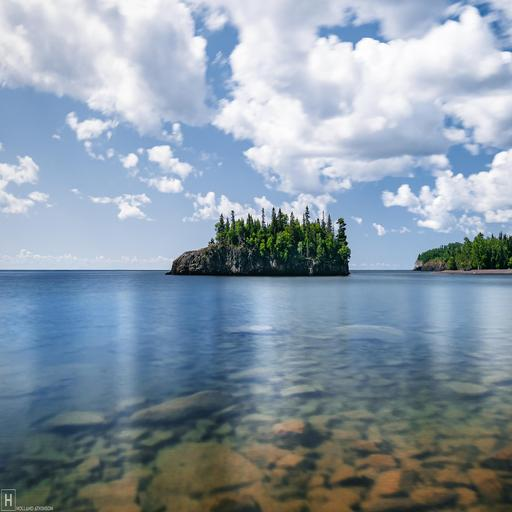

(512, 512, 3)


In [3]:
from IPython.display import Image
image = Image(filename=train_image_path[15928])
display(image)
image = cv2.imread(train_image_path[0], cv2.IMREAD_COLOR)
print(image.shape)

## **Watermark Detection Code (https://github.com/boomb0om/watermark-detection)**

In [4]:
# !git clone https://github.com/boomb0om/watermark-detection
# !cd watermark-detection
# !pip install -r requirements.txt

In [5]:
submission_csv = pd.read_csv(os.path.join(data_path,'submission.csv'))
submission_csv

,Label
0,0
1,0
2,0
3,0
4,0
...,...
6824,0
6825,0
6826,0
6827,0


In [6]:
%cd /home/fotavgg/Hackathon/watermark-detection

/home/fotavgg/Hackathon/watermark-detection


## **Finetuning Pretrained model**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from PIL import Image
import pandas as pd
import random
from tqdm import tqdm
import timm

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [8]:
import sys
sys.path.append('../')

In [11]:
input_size = 1024

In [12]:
class RandomRotation:
    def __init__(self, angles, p):
        self.p = p
        self.angles = angles

    def __call__(self, x):
        if random.random() < self.p:
            angle = random.choice(self.angles)
            return torchvision.transforms.functional.rotate(x, angle)
        else:
            return x

preprocess = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        RandomRotation([90, -90], 0.2),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize((input_size, input_size)),
        #transforms.CenterCrop(input_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
from glob import glob

data_path = '/home/fotavgg/Hackathon/Participants_Data_TWC'

train_image_path = glob(data_path + '/train/*.jpg')
test_image_path = glob(data_path + '/test/*.jpg')
print(train_image_path[0])

train_csv = pd.read_csv(os.path.join(data_path,'train.csv'))
train_csv['Image'] = train_csv['Image'].apply(lambda x: os.path.join(data_path,'train', x))
test_csv = pd.read_csv(os.path.join(data_path,'test.csv'))
test_csv['Image'] = test_csv['Image'].apply(lambda x: os.path.join(data_path,'test', x))

/home/fotavgg/Hackathon/Participants_Data_TWC/train/YJPL2I.jpg


In [14]:
from io import BytesIO
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class WatermarkDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop = True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx].Image).convert('RGB')
        tensor = self.transform(img)
        return tensor, self.df.loc[idx].Label

In [15]:
from sklearn.model_selection import train_test_split

train_df, valid_df= train_test_split(train_csv, test_size=0.2, shuffle=True, stratify=train_csv['Label'], random_state=42)

In [16]:
train_ds = WatermarkDataset(train_df, preprocess['train'])
valid_ds = WatermarkDataset(valid_df, preprocess['val'])

In [17]:
datasets = {
    'train': train_ds,
    'val': valid_ds,
}

In [27]:
from tqdm import tqdm
device = torch.device('cuda:4')

def train_model(model, dataloaders, criterion, optimizer, scheduler ,num_epochs=80):
    since = time.time()
    
    cnt = 0
    patient = 6
    val_acc_history = []
    train_acc_history = []
    
    best_model = None
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                if epoch_acc > best_acc:
                    cnt = 0
                    best_acc = epoch_acc
                    best_model = model
                    torch.save(model.state_dict(), "./weights/convnext-t_3layer-head_inp256_50epoch_720.pth")
            
                else:
                    cnt += 1
                    print(f"Don't improve loss [{cnt}/{patient}] |")
            
            if phase == 'val':
                scheduler.step(epoch_acc)
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if cnt == patient:
            print(f"patient={cnt}... Done!")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return best_model, train_acc_history, val_acc_history

In [28]:
from PIL import Image
from wmdetection.models import get_watermarks_detection_model
from wmdetection.pipelines.predictor import WatermarksPredictor

# checkpoint is automatically downloaded
model, transforms = get_watermarks_detection_model('convnext-tiny', fp16=False)

In [29]:
!pwd

/home/fotavgg/Hackathon


In [30]:
import timm
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [31]:
import torch.nn as nn
import timm
from efficientnet_pytorch import EfficientNet
from resnest.torch import resnest50

class Net(nn.Module):
    def __init__(self, model_name = None, mode = 'timm'):
        super().__init__()
        if mode == 'timm':
            self.model = timm.create_model('convnext_large_in22k', pretrained=True, num_classes=2)
            self.model.classifier = nn.Sequential(
                nn.Linear(in_features=1536, out_features=625),
                nn.ReLU(),
                nn.Dropout(p=0.3),
                nn.Linear(in_features=625, out_features=256),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=2),
            )
        else:
            num = 7
            self.model = EfficientNet.from_pretrained(f'efficientnet-b{num}',num_classes=2)
            self.model.classifier = nn.Sequential(
                nn.Linear(in_features=1536, out_features=625),
                nn.ReLU(),
                nn.Dropout(p=0.3),
                nn.Linear(in_features=625, out_features=256),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=2),
            )
            
    def forward(self, x):
        return self.model(x)
    
model = Net(mode = 'timm').to(device)

In [32]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=0.2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

BATCH_SIZE = 4

dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 
    for x in ['train', 'val']
}

In [33]:
%cd /home/fotavgg/Hackathon

/home/fotavgg/Hackathon


In [34]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "4"
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   model = nn.DataParallel(model)
    
model_ft, train_acc_history, val_acc_history = train_model(model, dataloaders_dict, criterion, optimizer, scheduler ,num_epochs=50)

Epoch 0/49
----------


100%|██████████| 3187/3187 [32:38<00:00,  1.63it/s]


train Loss: 0.6542 Acc: 0.6097


100%|██████████| 797/797 [03:16<00:00,  4.06it/s]


val Loss: 0.4430 Acc: 0.8550
Epoch 1/49
----------


100%|██████████| 3187/3187 [32:39<00:00,  1.63it/s]


train Loss: 0.0905 Acc: 0.9750


100%|██████████| 797/797 [03:16<00:00,  4.05it/s]


val Loss: 0.0492 Acc: 0.9871
Epoch 2/49
----------


100%|██████████| 3187/3187 [32:38<00:00,  1.63it/s]


train Loss: 0.0483 Acc: 0.9879


100%|██████████| 797/797 [03:16<00:00,  4.05it/s]


val Loss: 0.0468 Acc: 0.9874
Epoch 3/49
----------


100%|██████████| 3187/3187 [32:36<00:00,  1.63it/s]


train Loss: 0.0415 Acc: 0.9900


100%|██████████| 797/797 [03:17<00:00,  4.04it/s]


val Loss: 0.0536 Acc: 0.9856
Don't improve loss [1/6] |
Epoch 4/49
----------


100%|██████████| 3187/3187 [32:37<00:00,  1.63it/s]


train Loss: 0.0368 Acc: 0.9908


100%|██████████| 797/797 [03:16<00:00,  4.05it/s]


val Loss: 0.0420 Acc: 0.9887
Epoch 5/49
----------


100%|██████████| 3187/3187 [32:36<00:00,  1.63it/s]


train Loss: 0.0294 Acc: 0.9933


100%|██████████| 797/797 [03:17<00:00,  4.04it/s]


val Loss: 0.0581 Acc: 0.9893
Epoch 6/49
----------


100%|██████████| 3187/3187 [32:21<00:00,  1.64it/s]


train Loss: 0.0275 Acc: 0.9940


100%|██████████| 797/797 [03:21<00:00,  3.96it/s]


val Loss: 0.0441 Acc: 0.9896
Epoch 7/49
----------


100%|██████████| 3187/3187 [32:59<00:00,  1.61it/s]


train Loss: 0.0284 Acc: 0.9940


100%|██████████| 797/797 [03:21<00:00,  3.96it/s]


val Loss: 0.0454 Acc: 0.9896
Don't improve loss [1/6] |
Epoch 8/49
----------


100%|██████████| 3187/3187 [32:51<00:00,  1.62it/s]


train Loss: 0.0236 Acc: 0.9952


100%|██████████| 797/797 [03:19<00:00,  3.99it/s]


val Loss: 0.0398 Acc: 0.9896
Don't improve loss [2/6] |
Epoch 9/49
----------


100%|██████████| 3187/3187 [32:45<00:00,  1.62it/s]


train Loss: 0.0211 Acc: 0.9954


100%|██████████| 797/797 [03:20<00:00,  3.97it/s]


val Loss: 0.0419 Acc: 0.9893
Don't improve loss [3/6] |
Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch 10/49
----------


100%|██████████| 3187/3187 [32:52<00:00,  1.62it/s]


train Loss: 0.0197 Acc: 0.9967


100%|██████████| 797/797 [03:20<00:00,  3.98it/s]


val Loss: 0.0433 Acc: 0.9890
Don't improve loss [4/6] |
Epoch 11/49
----------


100%|██████████| 3187/3187 [32:49<00:00,  1.62it/s]


train Loss: 0.0205 Acc: 0.9964


100%|██████████| 797/797 [03:19<00:00,  3.99it/s]


val Loss: 0.0453 Acc: 0.9890
Don't improve loss [5/6] |
Epoch 12/49
----------


100%|██████████| 3187/3187 [32:43<00:00,  1.62it/s]


train Loss: 0.0171 Acc: 0.9974


100%|██████████| 797/797 [03:20<00:00,  3.98it/s]

val Loss: 0.0476 Acc: 0.9890
Don't improve loss [6/6] |
Epoch 00013: reducing learning rate of group 0 to 5.0000e-07.
patient=6... Done!
Training complete in 469m 24s
Best val Acc: 0.989645


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


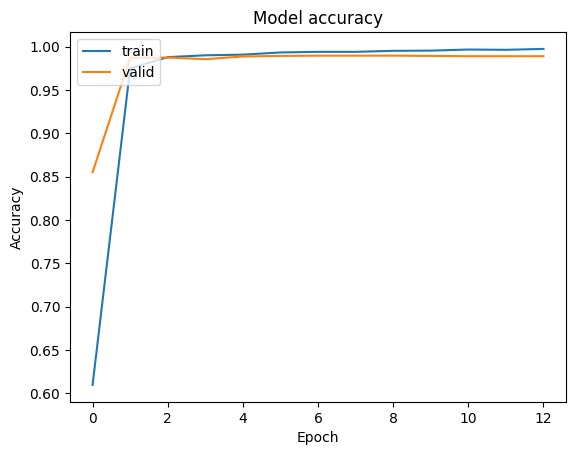

In [35]:
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [40]:
from PIL import Image
from wmdetection.models import get_watermarks_detection_model
from wmdetection.pipelines.predictor import WatermarksPredictor

predictor = WatermarksPredictor(model_ft, preprocess['val'], 'cuda:4')

result_list = []
for path in tqdm(test_csv['Image']):
    result = predictor.predict_image(Image.open(os.path.join(data_path,'test',path)))
    result_list.append(result)

submission_csv['Label'] = result_list

100%|██████████| 6829/6829 [21:58<00:00,  5.18it/s]


In [41]:
submission_csv.to_csv('/home/fotavgg/Hackathon/Participants_Data_TWC/50_iter_1024size_finetuning_submission.csv', index=False)